In [ ]:
%%bash
# Create the conda environment from environment.yml (run in a terminal or notebook).
# This will create an env named 'soundanalyzer' with the required packages.
conda env create -f environment.yml || conda env update -f environment.yml
# After creating/updating the env, register the kernel (run in the terminal):
# conda activate soundanalyzer
# python -m ipykernel install --user --name soundanalyzer --display-name "Python (soundanalyzer)"
# Note: running conda env changes from inside an active kernel may not affect the current kernel session.


  Using cached numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached pillow-12.1.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached pycparser-3.0-py3-none-any.whl.metadata (8.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 628.1 kB/s  0:00:26m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 636.7 kB/s  0:00:55m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 629.9 kB/s  0:00:13m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 630.5 kB/s  0:00:07 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 633.4 kB/s  0:00:02 eta 0:00:01
Using cached pillow-12.1.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
Using cached pyparsing-3.3.2-py3-none-any.whl (122 kB)
Using cached pycparser-3.0-py3-none-any.whl (48 kB)
   ━━━━━━━━━━

In [1]:
import numpy as np
import scipy.ndimage
import scipy.signal

class ERBSpectralProcessor:
    def __init__(self, sample_rate=44100, fft_size=4096, num_bands=60):
        self.sr = sample_rate
        self.fft_size = fft_size
        self.num_bands = num_bands  # Resolución visual (cuantas barras verás)
        
        # 1. Pre-calcular frecuencias FFT
        self.fft_freqs = np.fft.rfftfreq(fft_size, d=1/sample_rate)
        
        # 2. Construir el Banco de Filtros ERB
        self.filter_bank, self.center_freqs_hz = self._create_erb_filter_bank()
        
        # 3. Curva de Tilt (-3dB/oct compensación rosa)
        valid_freqs = np.maximum(self.fft_freqs, 1.0)
        self.tilt_curve = 3 * np.log2(valid_freqs)
        self.tilt_curve -= self.tilt_curve[0]

    def _hz_to_erb(self, freqs):
        return 21.4 * np.log10(0.00437 * freqs + 1)

    def _erb_to_hz(self, erb_nums):
        return (10**(erb_nums / 21.4) - 1) / 0.00437

    def _create_erb_filter_bank(self):
        min_freq = 20
        max_freq = self.sr / 2
        low_erb = self._hz_to_erb(min_freq)
        high_erb = self._hz_to_erb(max_freq)
        erb_points = np.linspace(low_erb, high_erb, self.num_bands + 2)
        hz_points = self._erb_to_hz(erb_points)
        bins = np.floor((self.fft_size + 1) * hz_points / self.sr).astype(int)
        
        fbank = np.zeros((self.num_bands, len(self.fft_freqs)))
        for m in range(1, self.num_bands + 1):
            f_m_minus, f_m, f_m_plus = bins[m-1], bins[m], bins[m+1]
            for k in range(f_m_minus, f_m):
                fbank[m-1, k] = (k - f_m_minus) / (f_m - f_m_minus)
            for k in range(f_m, f_m_plus):
                fbank[m-1, k] = (f_m_plus - k) / (f_m_plus - f_m)
        return fbank, hz_points[1:-1]

    def process_frame(self, audio_chunk, floor_factor=0.5):
        # Windowing y FFT
        window = np.hanning(len(audio_chunk))
        fft_raw = np.abs(np.fft.rfft(audio_chunk * window, n=self.fft_size))
        
        # Tilt Compensation (Lineal)
        tilt_linear = 10 ** (self.tilt_curve / 20)
        compensated_linear = fft_raw * tilt_linear
        
        # Conversión a dB para Noise Floor
        spectrum_db = 20 * np.log10(compensated_linear + 1e-9)
        
        # Noise Spectral Floor (Estimación del ruido de fondo)
        floor_db = scipy.ndimage.median_filter(spectrum_db, size=30)
        clean_db = spectrum_db - (floor_db * floor_factor)
        
        # Volver a lineal para sumar en bandas ERB
        clean_linear = 10**(clean_db / 20)
        
        # Suavizado ERB (Integración de energía)
        erb_energy = np.dot(self.filter_bank, clean_linear)
        erb_db = 20 * np.log10(erb_energy + 1e-9)

        return self.center_freqs_hz, erb_db

🎙️ GRABANDO (4.0s)... ¡Haz un silbido o ruido tonal AHORA!
✅ Procesando con Peak Hold y Tilt...


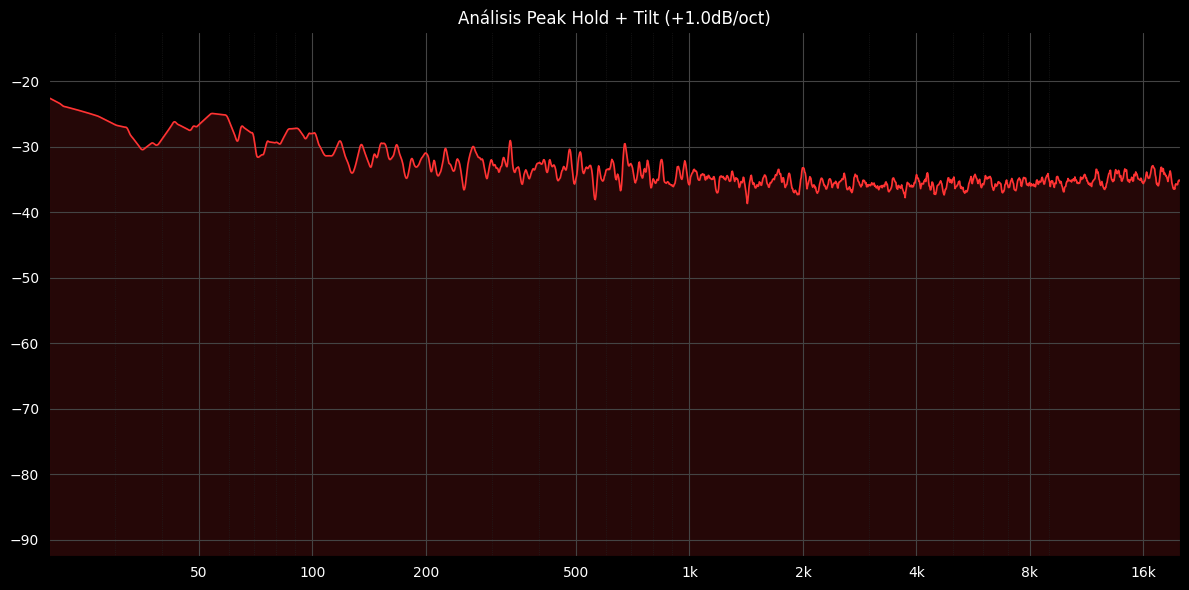

In [20]:
import numpy as np
import scipy.interpolate
import scipy.signal
import matplotlib.pyplot as plt
import sounddevice as sd

# --- PARÁMETROS ---
FS = 44100
DURATION = 4.0      # 4 segundos para darte tiempo de hacer ruido
FFT_SIZE = 8192     # Alta resolución

# --- 1. GRABACIÓN ---
print(f"🎙️ GRABANDO ({DURATION}s)... ¡Haz un silbido o ruido tonal AHORA!")
audio_data = sd.rec(int(DURATION * FS), samplerate=FS, channels=1, dtype='float32')
sd.wait()
audio_flat = audio_data.flatten()
print("✅ Procesando con Peak Hold y Tilt...")

# --- 2. MOTOR DSP (Tilt + Log Interpolation) ---
tilt = 1.0  # dB/octava para compensar el espectro rosa (opcional, pero recomendado)

def compute_spectrum_frame(audio_chunk, sr, fft_size):
    # A. FFT Standard
    window = np.hanning(len(audio_chunk))
    fft_raw = np.abs(np.fft.rfft(audio_chunk * window, n=fft_size))
    freqs_linear = np.fft.rfftfreq(fft_size, d=1/sr)
    
    # B. COMPENSACIÓN DE TILT (Reactivada)
    # Aplicamos +3dB por octava para aplanar el espectro visualmente
    # Evitamos log(0) empezando en 20Hz
    valid_freq_mask = freqs_linear > 20
    safe_freqs = np.maximum(freqs_linear, 20)
    
    # Curva de compensación: log2(f) * tilt
    tilt_db = tilt * np.log2(safe_freqs / 20.0) # Normalizado a 0dB en 20Hz
    
    # Magnitud en dB
    mag_db = 20 * np.log10(fft_raw + 1e-12)
    
    # Sumar Tilt solo donde es válido
    mag_db[valid_freq_mask] += tilt_db[valid_freq_mask]
    
    # C. INTERPOLACIÓN LOGARÍTMICA (Para resolución visual correcta)
    # Eje X objetivo (Logarítmico visualmente perfecto)
    num_display_points = 2000
    freqs_log = np.geomspace(20, sr/2, num_display_points)
    
    interpolator = scipy.interpolate.interp1d(freqs_linear, mag_db, kind='linear', fill_value="-60", bounds_error=False)
    spec_log = interpolator(freqs_log)
    
    return freqs_log, spec_log

# --- 3. PROCESAMIENTO CON PEAK HOLD ---
# En lugar de "Average", usamos "Max Hold" para capturar resonancias
num_chunks = len(audio_flat) // FFT_SIZE
peak_hold_spectrum = None

for i in range(num_chunks):
    chunk = audio_flat[i*FFT_SIZE : (i+1)*FFT_SIZE]
    f_log, spec_db = compute_spectrum_frame(chunk, FS, FFT_SIZE)
    
    if peak_hold_spectrum is None:
        peak_hold_spectrum = spec_db
    else:
        # LA CLAVE: Nos quedamos con el valor MÁXIMO histórico de cada frecuencia
        peak_hold_spectrum = np.maximum(peak_hold_spectrum, spec_db)

# --- 4. SUAVIZADO FINAL (Ligero) ---
# Un poco de Savitzky-Golay para que parezca "audio" y no "ruido digital"
final_curve = scipy.signal.savgol_filter(peak_hold_spectrum, window_length=11, polyorder=2)

# --- 5. VISUALIZACIÓN ---
plt.figure(figsize=(12, 6), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

# Dibujar curva
plt.plot(f_log, final_curve, color='#ff3333', linewidth=1.2, label='Peak Hold')

# Rellenar bajo la curva (estilo analizador moderno)
plt.fill_between(f_log, final_curve, -100, color='#ff3333', alpha=0.15)

# Configuración Ejes
plt.xscale('log')
plt.xlim(20, 20000)
# Ajustamos el límite Y dinámicamente para que se vea el pico
y_max = np.max(final_curve) + 10
y_min = y_max - 80 
plt.ylim(y_min, y_max)

# Grilla y Ticks
plt.grid(which='major', color='#444444', linestyle='-', linewidth=0.8)
plt.grid(which='minor', color='#222222', linestyle=':', linewidth=0.5)

xticks = [50, 100, 200, 500, 1000, 2000, 4000, 8000, 16000]
xtick_labels = ['50', '100', '200', '500', '1k', '2k', '4k', '8k', '16k']
plt.xticks(xticks, xtick_labels, color='white')
plt.yticks(color='white')

plt.title(f"Análisis Peak Hold + Tilt (+{tilt}dB/oct)", color='white')
plt.tight_layout()
plt.show()

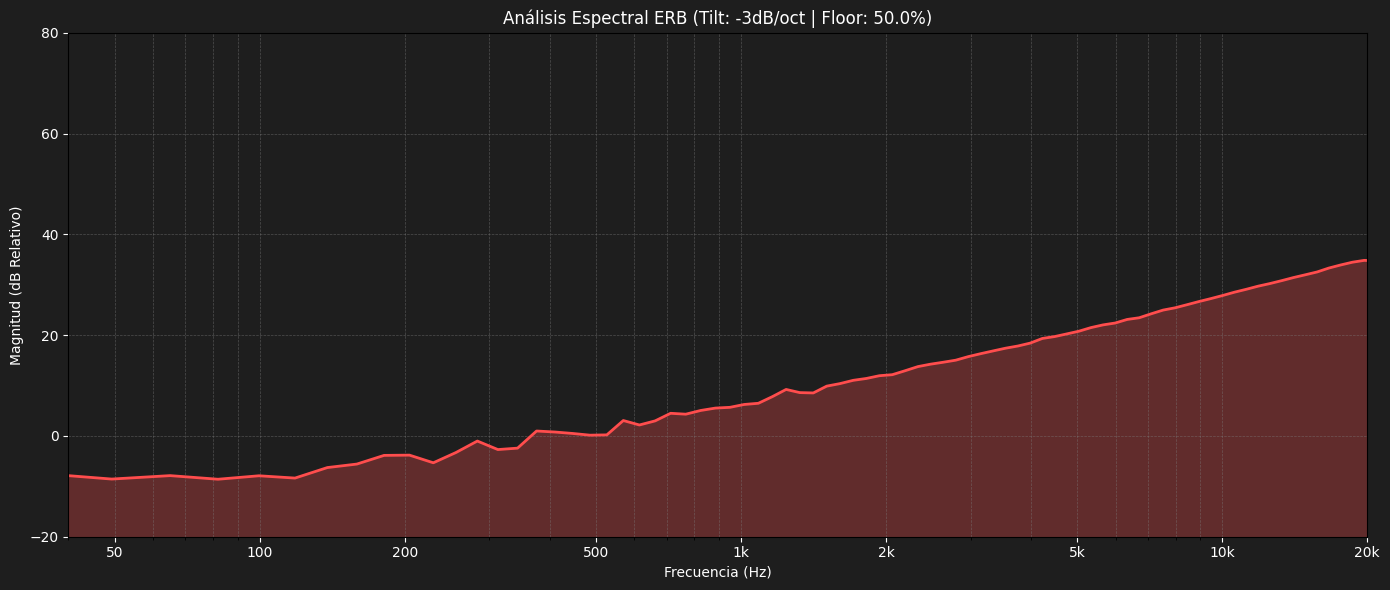

In [27]:
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
FFT_SIZE = 4096
FLOOR_SENSITIVITY = 0.5  # 0.0 = Ver todo el ruido, 1.0 = Limpieza agresiva

# Inicializar procesador
processor = ERBSpectralProcessor(sample_rate=FS, fft_size=FFT_SIZE, num_bands=80)

# Simulación de análisis: Procesamos el audio en trozos y promediamos el resultado
num_chunks = len(audio_flat) // FFT_SIZE
accumulated_db = np.zeros(processor.num_bands)
count = 0

for i in range(num_chunks):
    # Extraer trozo (chunk)
    start = i * FFT_SIZE
    chunk = audio_flat[start : start + FFT_SIZE]
    
    # Procesar usando la lógica ERB + Tilt
    freqs, db_values = processor.process_frame(chunk, floor_factor=FLOOR_SENSITIVITY)
    
    # Acumular para promediar (Max Hold es otra opción, aquí usamos Average)
    accumulated_db += db_values
    count += 1

# Calcular promedio final
final_db_spectrum = accumulated_db / count

# --- VISUALIZACIÓN ---
plt.figure(figsize=(14, 6), facecolor='#1e1e1e') # Fondo oscuro estilo plugin
ax = plt.gca()
ax.set_facecolor('#1e1e1e')

# Dibujar espectro
plt.plot(freqs, final_db_spectrum, color='#ff4d4d', linewidth=2, label='Energía Promedio (ERB)')
plt.fill_between(freqs, final_db_spectrum, -100, color='#ff4d4d', alpha=0.3)

# Configuración de Ejes
plt.xscale('log') # Eje X logarítmico para familiaridad musical
plt.xlim(40, 20000)
plt.ylim(-20, 80) # Ajustar según el volumen de tu micrófono
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5, which='both')

# Etiquetas
plt.title(f"Análisis Espectral ERB (Tilt: -3dB/oct | Floor: {FLOOR_SENSITIVITY*100}%)", color='white')
plt.xlabel("Frecuencia (Hz)", color='white')
plt.ylabel("Magnitud (dB Relativo)", color='white')
plt.tick_params(axis='both', colors='white')
plt.xticks([50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], 
           ['50', '100', '200', '500', '1k', '2k', '5k', '10k', '20k'])

plt.tight_layout()
plt.show()